<a href="https://colab.research.google.com/github/mjgpinheiro/AI-Strategies-StockMarket/blob/main/OU_BTCUSD_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching historical BTC/USDT data from CoinGecko...
Data fetched successfully.
Selling at 65607.80630933864
Stop Loss: Closing Short at 65869.08869010779, Capital: 900
Selling at 65605.49316578607
Stop Loss: Closing Short at 65762.89489896805, Capital: 800
Buying at 65814.50773734815
Stop Loss: Closing Long at 65636.22650367954, Capital: 700
Buying at 65802.63199782168
Take Profit: Closing Long at 65955.12768292298, Capital: 850
Buying at 65898.99855442859
Stop Loss: Closing Long at 65586.45298542893, Capital: 750
Selling at 65527.11644598126
Take Profit: Closing Short at 64746.39422306732, Capital: 900
Selling at 64396.475068537344
Stop Loss: Closing Short at 64537.123463429336, Capital: 800
Selling at 64349.82336854003
Stop Loss: Closing Short at 64587.99699957813, Capital: 700
Selling at 64318.776746778014
Take Profit: Closing Short at 63616.34230857029, Capital: 850
Selling at 63568.17951393721
Stop Loss: Closing Short at 63865.76587841092, Capital: 750
Selling at 64022.25371999935

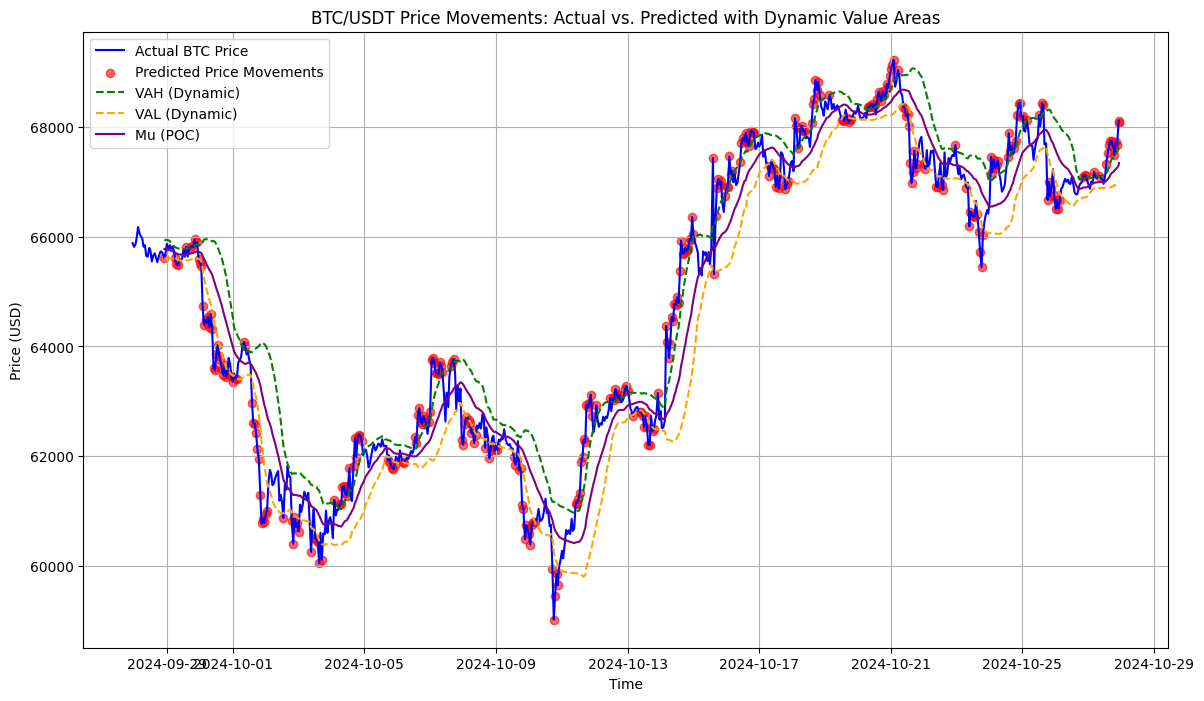

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
from scipy.stats import linregress
import matplotlib.pyplot as plt
from datetime import datetime
from time import sleep

# Step 1: Fetching Historical BTC/USDT Data
def fetch_historical_data(days=30):
    try:
        print("Fetching historical BTC/USDT data from CoinGecko...")
        url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days={days}"
        response = requests.get(url)
        data = response.json()

        prices = data['prices']
        df = pd.DataFrame(prices, columns=['timestamp', 'Close'])
        df['CloseTime'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.drop(columns='timestamp', inplace=True)

        print("Data fetched successfully.")
        return df[['CloseTime', 'Close']]
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Step 2: Function to Estimate Parameters (Theta, Mu, Sigma)
def estimate_ou_parameters(data):
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data = data.dropna()

    X_t_minus_1 = data['Close'].shift(1).dropna().values.flatten()
    X_t = data['Close'][1:].values.flatten()
    regression_result = linregress(X_t_minus_1, X_t)

    theta = 1 - regression_result.slope
    mu = regression_result.intercept / (1 - regression_result.slope)
    sigma = data['Log_Returns'].std()

    return theta, mu, sigma

# Step 3: Adjusted Function to Calculate Dynamic VAH, VAL, POC
def calculate_dynamic_value_areas(data, window=24):
    """Calculate rolling VAH, VAL, and POC using a moving window."""
    data['POC'] = data['Close'].rolling(window=window).mean()  # Rolling Point of Control
    data['VAH'] = data['POC'] + data['Close'].rolling(window=window).std()  # Upper Value Area High
    data['VAL'] = data['POC'] - data['Close'].rolling(window=window).std()  # Lower Value Area Low
    return data

# Step 4: Update Backtesting Strategy to Use Dynamic Value Areas
def backtest_dynamic_strategy(data, stop_loss=200, take_profit=200):
    # Calculate dynamic value areas
    data = calculate_dynamic_value_areas(data)

    data['Signal'] = 0  # 0 means no action, 1 for buy, -1 for sell
    data['Predicted_Close'] = None  # Placeholder for visualization

    # Generate signals based on dynamic value area
    for index, row in data.iterrows():
        price = row['Close']
        vah = row['VAH']
        val = row['VAL']
        if pd.notna(vah) and pd.notna(val):
            if price > vah:
                data.loc[index, 'Signal'] = 1  # BUY signal
                data.loc[index, 'Predicted_Close'] = price  # Mark predicted price for visualization
            elif price < val:
                data.loc[index, 'Signal'] = -1  # SELL signal
                data.loc[index, 'Predicted_Close'] = price  # Mark predicted price for visualization

    # Backtesting logic with stop-loss and take-profit
    initial_capital = 1000
    capital = initial_capital
    position = 0
    entry_price = 0
    trade_history = []  # Track trades

    for index, row in data.iterrows():
        if row['Signal'] == 1 and position == 0:
            # BUY
            position = 1
            entry_price = row['Close']
            trade_history.append({'action': 'buy', 'price': entry_price, 'time': row['CloseTime']})
            print(f"Buying at {entry_price}")

        elif row['Signal'] == -1 and position == 0:
            # SELL
            position = -1
            entry_price = row['Close']
            trade_history.append({'action': 'sell', 'price': entry_price, 'time': row['CloseTime']})
            print(f"Selling at {entry_price}")

        # Exit conditions for long positions
        if position == 1:
            if (row['Close'] - entry_price) >= take_profit:
                capital += take_profit
                position = 0
                trade_history.append({'action': 'take_profit', 'price': row['Close'], 'time': row['CloseTime'], 'capital': capital})
                print(f"Take Profit: Closing Long at {row['Close']}, Capital: {capital}")

            elif (entry_price - row['Close']) >= stop_loss:
                capital -= stop_loss
                position = 0
                trade_history.append({'action': 'stop_loss', 'price': row['Close'], 'time': row['CloseTime'], 'capital': capital})
                print(f"Stop Loss: Closing Long at {row['Close']}, Capital: {capital}")

        # Exit conditions for short positions
        if position == -1:
            if (entry_price - row['Close']) >= take_profit:
                capital += take_profit
                position = 0
                trade_history.append({'action': 'take_profit', 'price': row['Close'], 'time': row['CloseTime'], 'capital': capital})
                print(f"Take Profit: Closing Short at {row['Close']}, Capital: {capital}")

            elif (row['Close'] - entry_price) >= stop_loss:
                capital -= stop_loss
                position = 0
                trade_history.append({'action': 'stop_loss', 'price': row['Close'], 'time': row['CloseTime'], 'capital': capital})
                print(f"Stop Loss: Closing Short at {row['Close']}, Capital: {capital}")

    # Final Results
    total_return = (capital - initial_capital) / initial_capital * 100
    print(f"Final Capital: {capital}")
    print(f"Total Return: {total_return}%")

    # Step 5: Visualization of Actual vs. Predicted Movements
    plt.figure(figsize=(14, 8))
    plt.plot(data['CloseTime'], data['Close'], label='Actual BTC Price', color='blue')
    plt.scatter(data['CloseTime'], data['Predicted_Close'], color='red', label='Predicted Price Movements', alpha=0.6)
    plt.plot(data['CloseTime'], data['VAH'], linestyle='--', color='green', label='VAH (Dynamic)')
    plt.plot(data['CloseTime'], data['VAL'], linestyle='--', color='orange', label='VAL (Dynamic)')
    plt.plot(data['CloseTime'], data['POC'], linestyle='-', color='purple', label='Mu (POC)')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.title("BTC/USDT Price Movements: Actual vs. Predicted with Dynamic Value Areas")
    plt.grid(True)
    plt.show()

# Step 6: Fetch Data and Backtest
historical_data = fetch_historical_data(days=30)
if historical_data is not None:
    backtest_dynamic_strategy(historical_data, stop_loss=100, take_profit=150)
